# Failing VQE on hardware case (error 1500)

> This is the failing case of VQE running on IBM hardware.

[Basic short circuits](./../../GENERAL/qiskit-tryouts/RUNNING_BASIC_CIRCUIT.ipynb) work for similar hardware run cases.

Also tried:
- adding `scheduling_method="alap"` (thinking it's a scheduling problem), 
- disabling dynamic decoupling (decoupling problem?), 
- transpiling the circuit multiple times (thinking it's a circuit-observable mismatch)

Currently contacting IBM Support.

Python environment details:

```bash
Python 3.12.3

qiskit-nature
pyscf
matplotlib
qiskit-ibm-runtime
pylatexenc
```

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
from matplotlib import pyplot as plt

driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
problem = driver.run()

print("MOLECULAR STRUCTURE:")
print("orbitals: ", problem.num_spatial_orbitals)
print("particles: ", problem.num_particles)

from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())
print("\nQUBIT HAMILTONIAN:")
print(qubit_hamiltonian)

# optimizer = L_BFGS_B(maxfun=20)

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

initial_point = np.zeros(ansatz.num_parameters)
results = []

MOLECULAR STRUCTURE:
orbitals:  2
particles:  (1, 1)

QUBIT HAMILTONIAN:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting backend")

/tmp/ipykernel_498165/3501619356.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Done getting backend


In [3]:
from qiskit import transpile
from qiskit_ibm_runtime import EstimatorV2 as Estimator

transpiled_qcs = transpile(
    [ansatz],
    optimization_level=1,
    backend=backend,
    scheduling_method="alap",
    layout_method="trivial",
)
observable = qubit_hamiltonian.apply_layout(transpiled_qcs[0].layout)

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"

In [4]:
from datetime import datetime

def estimate_energy(parameters):
    job = estimator.run([(transpiled_qcs[0], observable, parameters)])
    print(f"{datetime.now()} Job submitted: {job.job_id()}")

    result = job.result()[0].data.evs
    results.append(result)
    return result

result = estimate_energy(initial_point)
print(f"{datetime.now()} Result: {result}")

2025-05-21 08:50:17.290393 Job submitted: d0pqfa5b5pe0008ceve0
2025-05-21 09:11:42.476021 Result: -1.229128025669943


In [ ]:
print(transpiled_qcs[0].depth())
print(transpiled_qcs[0].num_qubits)
print(backend.configuration().num_qubits)
print(qubit_hamiltonian.num_qubits)
print(observable.num_qubits)
print(transpiled_qcs[0].layout)
print(transpiled_qcs[0].layout.initial_layout)
print(observable)
print(transpiled_qcs[0].draw(output='text'))

> Last cell returns [this output](./Debugging_output.txt)

This is the dashboard of IBM Quantum:

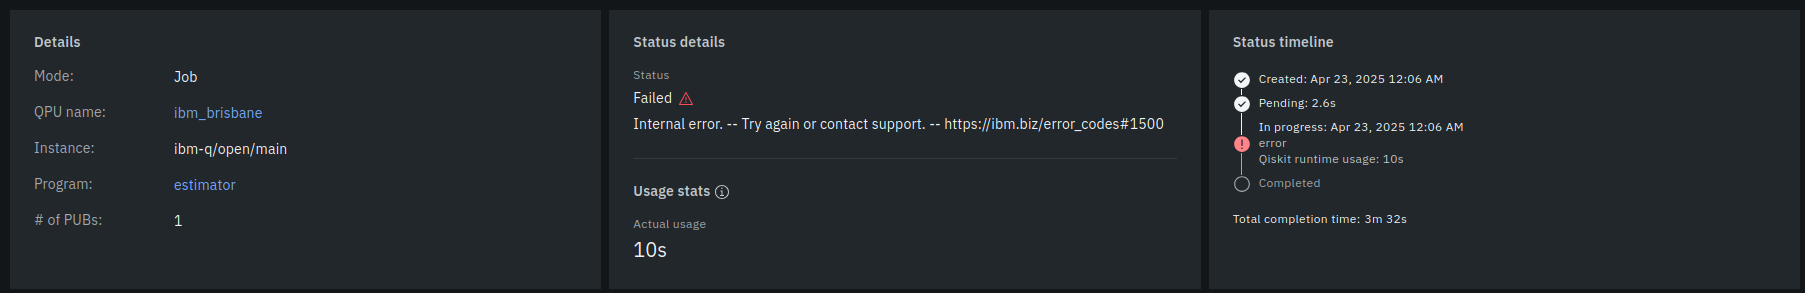